In [1]:
import glob
import pandas as pd
import json

projects = ["djanjo", "flask", "pytorch", "pandas"]
dfs=[]

for project in projects:
    filenames = glob.glob(f"../output/pytlint/{project}/*.json")
    for filename in filenames:
        with open(filename) as json_data:
            data = json.load(json_data)
            df = pd.json_normalize(data)
            df['project'] = project
            dfs.append(df)




In [2]:
df_py = pd.concat(dfs, ignore_index=True)

df_py.head(5)

,type,module,obj,line,column,endLine,endColumn,path,symbol,message,message-id,project
0,warning,flask.cli,FlaskGroup.list_commands,605,15,605,24,projects/py/flask/src/flask/cli.py,broad-except,Catching too general exception Exception,W0703,flask
1,warning,flask.cli,run_command,898,11,898,20,projects/py/flask/src/flask/cli.py,broad-except,Catching too general exception Exception,W0703,flask
2,warning,test_reqctx,test_teardown_with_previous_exception,39,11,39,20,projects/py/flask/tests/test_reqctx.py,broad-except,Catching too general exception Exception,W0703,flask
3,warning,test_reqctx,test_teardown_with_handled_exception,58,15,58,24,projects/py/flask/tests/test_reqctx.py,broad-except,Catching too general exception Exception,W0703,flask
4,warning,test_appctx,test_app_tearing_down_with_previous_exception,66,11,66,20,projects/py/flask/tests/test_appctx.py,broad-except,Catching too general exception Exception,W0703,flask


In [3]:
df_py.groupby(['project','message-id'])['message-id'].count()

project  message-id
flask    W0703           9
pandas   W0703          24
         W0706           2
         W0707          23
pytorch  E0702           5
         E0704           2
         W0702           4
         W0703         253
         W0706           6
         W0707           9
         W0715          11
Name: message-id, dtype: int64

In [4]:
import psycopg2

conn = psycopg2.connect("host={} user={} dbname=exception_miner password={} port={}".format("127.0.0.1", "exception_miner", "exception_miner", "5432"))
conn.set_session(autocommit=True)
cur = conn.cursor()

cur.execute("""CREATE TABLE IF NOT EXISTS exceptions_pylint (type VARCHAR(255), module VARCHAR(255), obj VARCHAR(255), beginLine INT, beginColumn INT,	endLine INT, endColumn INT, path VARCHAR(255), symbol VARCHAR(255), message VARCHAR(255), message_id VARCHAR(255), project VARCHAR(255))""")

cur.execute("""DELETE FROM exceptions_pylint;""")

for i, row in df_py.iterrows():
    #print(row)
    cur.execute(("""INSERT INTO exceptions_pylint (type, module, obj, beginLine, beginColumn, endLine, endColumn, path, symbol, message, message_id, project)
                            VALUES (%s, %s, %s, %s, %s, %s,%s, %s, %s, %s, %s, %s  );"""), list(row))

Python Parser

In [1]:
import glob
import pandas as pd
import json

projects = ["django", "flask", "pytorch", "pandas"]
dfs=[]

for project in projects:
    #filenames = glob.glob(f"../output/parser/*.csv")
    #print(filename)
    df = pd.read_csv(f"../output/parser/{project}_stats.csv")
    df['project'] = project
    dfs.append(df)


In [2]:
df = pd.concat(dfs, ignore_index=True)
df.head(5)

file       function  \
0  /home/eric3/git/exception-miner/projects/py/dj...  send_messages   
1  /home/eric3/git/exception-miner/projects/py/dj...  send_messages   
2  /home/eric3/git/exception-miner/projects/py/dj...       __init__   
3  /home/eric3/git/exception-miner/projects/py/dj...  mail_managers   
4  /home/eric3/git/exception-miner/projects/py/dj...    mail_admins   

                                           func_body  n_try_except  \
0  def send_messages(self, email_messages):\n    ...             0   
1  def send_messages(self, messages):\n        ""...             0   
2  def __init__(self, *args, **kwargs):\n        ...             0   
3  def mail_managers(\n    subject, message, fail...             0   
4  def mail_admins(\n    subject, message, fail_s...             0   

   n_try_pass  n_generic_except  n_raise  n_captures_broad_raise  \
0           0                 0        0                       0   
1           0                 0        0                       0   
2           0                 0        0                       0   
3           0                 0        1                       0   
4           0                 0        1                       0   

   n_captures_try_except_raise  n_captures_misplaced_bare_raise  n_try_else  \
0                            0                                0           0   
1                            0                                0           0   
2                            0                                0           0   
3                            0                                0           0   
4                            0                                0           0   

   n_try_return str_except_identifiers str_raise_identifiers except_block  \
0             0                    NaN                   NaN           []   
1             0                    NaN                   NaN           []   
2             0                    NaN                   NaN           []   
3             0                    NaN            ValueError           []   
4             0                    NaN            ValueError           []   

  project  
0  django  
1  django  
2  django  
3  django  
4  django

In [7]:
df[df['n_try_except'] > 1]

,file,function,func_body,n_try_except,n_try_pass,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,except_block,project
84,/home/eric3/git/exception-miner/projects/py/dj...,parse_apps_and_model_labels,def parse_apps_and_model_labels(labels):\n ...,2,0,0,2,0,0,0,0,0,LookupError LookupError,CommandError CommandError,['except LookupError:\n raise C...,django
98,/home/eric3/git/exception-miner/projects/py/dj...,handle,"def handle(self, app_or_project, name, target=...",3,0,0,4,0,0,0,0,0,FileExistsError OSError OSError,CommandError CommandError CommandError Command...,['except FileExistsError:\n rai...,django
181,/home/eric3/git/exception-miner/projects/py/dj...,run_tests,"def run_tests(self, test_labels, extra_tests=N...",2,0,2,2,0,1,0,0,0,Exception Exception,NaN,['except Exception:\n run_failed = ...,django
208,/home/eric3/git/exception-miner/projects/py/dj...,run,"def run(self, result):\n """"""\n D...",2,0,0,0,0,0,0,0,0,multiprocessing TimeoutError StopIteration,NaN,['except multiprocessing.TimeoutError:\n ...,django
373,/home/eric3/git/exception-miner/projects/py/dj...,setUpClass,def setUpClass(cls):\n super().setUpCla...,2,0,2,2,0,2,0,0,0,Exception Exception,NaN,['except Exception:\n cls._...,django
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101779,/home/eric3/git/exception-miner/projects/py/pa...,_check_join,"def _check_join(left, right, result, join_col,...",2,0,0,2,0,0,0,2,0,NaN,NaN,NaN,pandas
102764,/home/eric3/git/exception-miner/projects/py/pa...,test_apply_out_of_range,"def test_apply_out_of_range(request, tz_naive_...",2,2,0,2,0,0,0,0,0,OutOfBoundsDatetime,NaN,NaN,pandas
110157,/home/eric3/git/exception-miner/projects/py/pa...,get_versions,"def get_versions():\n """"""Get version inform...",4,3,0,4,0,0,0,0,2,NotThisMethod NameError NotThisMethod NotThis...,NaN,NaN,pandas
110450,/home/eric3/git/exception-miner/projects/py/pa...,linkcode_resolve,"def linkcode_resolve(domain, info):\n """"""\n...",6,0,0,6,0,0,0,0,0,AttributeError TypeError TypeError OSError,NaN,NaN,pandas


In [58]:
df.shape

(110492, 15)

In [59]:
#TODO:
#Analisar Duplicados
df[df.duplicated()]

file           function  \
292     /home/eric3/git/exception-miner/projects/py/dj...           to_bytes   
298     /home/eric3/git/exception-miner/projects/py/dj...           __init__   
554     /home/eric3/git/exception-miner/projects/py/dj...           strftime   
590     /home/eric3/git/exception-miner/projects/py/dj...             to_str   
739     /home/eric3/git/exception-miner/projects/py/dj...     state_forwards   
...                                                   ...                ...   
107863  /home/eric3/git/exception-miner/projects/py/pa...  test_int_internal   
109808  /home/eric3/git/exception-miner/projects/py/pa...               prng   
109816  /home/eric3/git/exception-miner/projects/py/pa...            samples   
109817  /home/eric3/git/exception-miner/projects/py/pa...               prng   
110486  /home/eric3/git/exception-miner/projects/py/pa...   finalize_options   

                                                func_body  n_try_except  \
292     def to_bytes(s):\n        return force_bytes(s...             0   
298     def __init__(self, enforce_csrf_checks=True, *...             0   
554     def strftime(self, fmt):\n        return strft...             0   
590     def to_str(s):\n            return str(s) if s...             0   
739     def state_forwards(self, app_label, state):\n ...             0   
...                                                   ...           ...   
107863  def test_int_internal(self):\n        idx = ma...             0   
109808  def prng(self):\n        return np.random.Rand...             0   
109816  def samples(self):\n        return np.sin(np.l...             0   
109817  def prng(self):\n        return np.random.Rand...             0   
110486          def finalize_options(self):\n        pass             0   

        n_try_pass  n_generic_except  n_raise  n_captures_broad_raise  \
292              0                 0        0                       0   
298              0                 0        0                       0   
554              0                 0        0                       0   
590              0                 0        0                       0   
739              0                 0        0                       0   
...            ...               ...      ...                     ...   
107863           0                 0        0                       0   
109808           0                 0        0                       0   
109816           0                 0        0                       0   
109817           0                 0        0                       0   
110486           0                 0        0                       0   

        n_captures_try_except_raise  n_captures_misplaced_bare_raise  \
292                               0                                0   
298                               0                                0   
554                               0                                0   
590                               0                                0   
739                               0                                0   
...                             ...                              ...   
107863                            0                                0   
109808                            0                                0   
109816                            0                                0   
109817                            0                                0   
110486                            0                                0   

        n_try_else  n_try_return str_except_identifiers str_raise_identifiers  \
292              0             0                    NaN                   NaN   
298              0             0                    NaN                   NaN   
554              0             0                    NaN                   NaN   
590              0             0                    NaN                   NaN   
739              0             0            

In [60]:
df = df.drop_duplicates().shape

In [61]:
df[df['n_generic_except'] > 1].values[0]

TypeError: tuple indices must be integers or slices, not str

In [ ]:
import psycopg2

conn = psycopg2.connect("host={} user={} dbname=exception_miner password={} port={}".format("127.0.0.1", "exception_miner", "exception_miner", "5432"))
conn.set_session(autocommit=True)
cur = conn.cursor()

cur.execute("""CREATE TABLE IF NOT EXISTS exceptions_parser (file VARCHAR(255), function VARCHAR(255), n_try_except INT, n_try_pass INT, n_generic_except INT, project VARCHAR(255))""")

cur.execute("""DELETE FROM exceptions_parser;""")

for i, row in df.iterrows():
    #print(row)
    cur.execute(("""INSERT INTO exceptions_parser (file, function, n_try_except, n_try_pass, n_generic_except, project)
                            VALUES (%s, %s, %s, %s, %s, %s );"""), list(row))

Analyzing the Control Flow and Code

In [14]:
import glob
import pandas as pd
import json

projects = ["django", "flask", "pytorch", "pandas"]
dfs=[]

for project in projects:
    #filenames = glob.glob(f"../output/parser/*.csv")
    #print(filename)
    df = pd.read_csv(f"../output/parser/{project}_stats.csv")
    df['project'] = project
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [15]:
df.project.unique()

array(['django', 'flask', 'pytorch', 'pandas'], dtype=object)

In [16]:
df.shape

(119038, 15)

In [17]:
df.head(5)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,project
0,/home/r4ph/desenv/exception-miner/projects/py/...,_path,"def _path(route, view, kwargs=None, name=None,...",0,0,0,0,0,0,0,0,0,0,NaN,django
1,/home/r4ph/desenv/exception-miner/projects/py/...,include,"def include(arg, namespace=None):\n app_nam...",1,0,0,0,1,0,0,0,0,0,ValueError,django
2,/home/r4ph/desenv/exception-miner/projects/py/...,_reverse_with_prefix,"def _reverse_with_prefix(self, lookup_view, _p...",1,0,0,0,1,0,0,0,0,0,ValueError,django
3,/home/r4ph/desenv/exception-miner/projects/py/...,reverse,"def reverse(self, lookup_view, *args, **kwargs...",0,0,0,0,0,0,0,0,0,0,NaN,django
4,/home/r4ph/desenv/exception-miner/projects/py/...,resolve_error_handler,"def resolve_error_handler(self, view_type):\n ...",0,0,0,0,0,0,0,0,0,0,NaN,django


In [18]:
df[df['str_except_identifiers'].notna()].head(10)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,project
1,/home/r4ph/desenv/exception-miner/projects/py/...,include,"def include(arg, namespace=None):\n app_nam...",1,0,0,0,1,0,0,0,0,0,ValueError,django
2,/home/r4ph/desenv/exception-miner/projects/py/...,_reverse_with_prefix,"def _reverse_with_prefix(self, lookup_view, _p...",1,0,0,0,1,0,0,0,0,0,ValueError,django
15,/home/r4ph/desenv/exception-miner/projects/py/...,_check_custom_error_handlers,def _check_custom_error_handlers(self):\n ...,2,0,0,0,2,0,0,0,0,0,TypeError,django
36,/home/r4ph/desenv/exception-miner/projects/py/...,match,"def match(self, path):\n match = self.r...",1,0,0,0,1,0,0,0,0,0,ValueError,django
56,/home/r4ph/desenv/exception-miner/projects/py/...,translate_url,"def translate_url(url, lang_code):\n """"""\n ...",2,2,0,0,2,0,0,0,2,0,Resolver404 NoReverseMatch,django
57,/home/r4ph/desenv/exception-miner/projects/py/...,is_valid_path,"def is_valid_path(path, urlconf=None):\n """"...",1,0,0,0,1,0,0,0,0,1,Resolver404,django
60,/home/r4ph/desenv/exception-miner/projects/py/...,clear_script_prefix,"def clear_script_prefix():\n """"""\n Unset...",1,1,0,0,1,0,0,0,0,0,AttributeError,django
64,/home/r4ph/desenv/exception-miner/projects/py/...,reverse,"def reverse(viewname, urlconf=None, args=None,...",2,1,0,0,2,0,0,0,0,0,KeyError,django
66,/home/r4ph/desenv/exception-miner/projects/py/...,get_mod_func,def get_mod_func(callback):\n # Convert 'dj...,1,0,0,0,1,0,0,0,0,0,ValueError,django
67,/home/r4ph/desenv/exception-miner/projects/py/...,get_callable,"def get_callable(lookup_view):\n """"""\n R...",2,0,0,0,2,0,0,0,2,0,ImportError AttributeError,django


In [19]:
df.iloc[428,:].func_body

'def _remove_prefetched_objects(self):\n            try:\n                self.instance._prefetched_objects_cache.pop(self.prefetch_cache_name)\n            except (AttributeError, KeyError):\n                pass'

In [20]:
df.iloc[428,:].str_except_identifiers

nan

In [21]:
df[df['n_finally'] > 1]#.count()

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,project
5359,/home/r4ph/desenv/exception-miner/projects/py/...,save,"def save(self, must_create=False):\n if...",3,1,2,0,3,0,0,0,0,0,FileNotFoundError FileExistsError,django
7641,/home/r4ph/desenv/exception-miner/projects/py/...,_save,"def _save(self, name, content):\n full_...",2,0,2,0,2,0,0,0,1,0,FileExistsError FileExistsError,django
9604,/home/r4ph/desenv/exception-miner/projects/py/...,test_no_auto_transaction,def test_no_auto_transaction(self):\n o...,0,0,3,0,0,0,0,0,0,0,NaN,django
10263,/home/r4ph/desenv/exception-miner/projects/py/...,test_custom_implementation_year_exact,def test_custom_implementation_year_exact(self...,0,0,2,0,0,0,0,0,0,0,NaN,django
13807,/home/r4ph/desenv/exception-miner/projects/py/...,test_disallowed_host_doesnt_crash,def test_disallowed_host_doesnt_crash(self):\n...,0,0,2,0,0,0,0,0,0,0,NaN,django
17057,/home/r4ph/desenv/exception-miner/projects/py/...,test_related_object,def test_related_object(self):\n public...,0,0,2,0,0,0,0,0,0,0,NaN,django
33959,/home/r4ph/desenv/exception-miner/projects/py/...,test_single_checkpoint,def test_single_checkpoint(self):\n # t...,0,0,2,0,0,0,0,0,0,0,NaN,pytorch
37369,/home/r4ph/desenv/exception-miner/projects/py/...,create_proxy,"def create_proxy(self, kind, target, args, kwa...",1,0,2,1,1,0,0,0,0,0,NaN,pytorch
40536,/home/r4ph/desenv/exception-miner/projects/py/...,wrapper,"def wrapper(*args, **kwargs):\n # Save ...",2,0,2,0,2,0,0,0,0,1,KeyError KeyError,pytorch
40537,/home/r4ph/desenv/exception-miner/projects/py/...,with_nccl_blocking_wait,"def with_nccl_blocking_wait(func):\n """"""\n ...",2,0,2,0,2,0,0,0,0,1,KeyError KeyError,pytorch


In [22]:
df.iloc[92315, :].func_body

'def init_windows_clipboard():\n    global HGLOBAL, LPVOID, DWORD, LPCSTR, INT\n    global HWND, HINSTANCE, HMENU, BOOL, UINT, HANDLE\n    from ctypes.wintypes import (\n        BOOL,\n        DWORD,\n        HANDLE,\n        HGLOBAL,\n        HINSTANCE,\n        HMENU,\n        HWND,\n        INT,\n        LPCSTR,\n        LPVOID,\n        UINT,\n    )\n\n    windll = ctypes.windll\n    msvcrt = ctypes.CDLL("msvcrt")\n\n    safeCreateWindowExA = CheckedCall(windll.user32.CreateWindowExA)\n    safeCreateWindowExA.argtypes = [\n        DWORD,\n        LPCSTR,\n        LPCSTR,\n        DWORD,\n        INT,\n        INT,\n        INT,\n        INT,\n        HWND,\n        HMENU,\n        HINSTANCE,\n        LPVOID,\n    ]\n    safeCreateWindowExA.restype = HWND\n\n    safeDestroyWindow = CheckedCall(windll.user32.DestroyWindow)\n    safeDestroyWindow.argtypes = [HWND]\n    safeDestroyWindow.restype = BOOL\n\n    OpenClipboard = windll.user32.OpenClipboard\n    OpenClipboard.argtypes = [HW

In [23]:
from pandasql import sqldf

q = """SELECT asd.project,
       asd.n_functions,
       asd.n_try_except,
       ROUND((CAST(asd.n_try_except AS FLOAT) / CAST(asd.n_functions AS FLOAT)), 4) * 100                 as perc_trys_func,
       asd.n_try_return,
       ROUND((CAST(asd.n_try_return AS FLOAT) / CAST (asd.n_functions AS FLOAT)), 4) * 100  as perc_n_try_return,
       asd.n_generic_except,
       ROUND((CAST(asd.n_generic_except AS FLOAT) / CAST(asd.n_try_except AS FLOAT)), 4) * 100            as perc_try_generic,
       asd.n_try_pass,
       ROUND((CAST(asd.n_try_pass AS FLOAT) / CAST(asd.n_try_except AS FLOAT)), 4) * 100                  as perc_try_pass,
       asd.n_try_else,
       ROUND((CAST(asd.n_try_else AS FLOAT) / CAST (asd.n_try_except AS FLOAT)), 4) * 100  as perc_n_try_else,
       asd.n_raise,
       ROUND((CAST(asd.n_raise AS FLOAT) / CAST(asd.n_functions AS FLOAT)), 4) * 100 as perc_raise,
       asd.n_captures_try_except_raise,
       ROUND((CAST(asd.n_captures_try_except_raise AS FLOAT) / CAST(asd.n_raise AS FLOAT)), 4) * 100 as perc_try_except_raise,
       asd.n_captures_broad_raise,
       ROUND((CAST(asd.n_captures_broad_raise AS FLOAT) / CAST(asd.n_raise AS FLOAT)), 4) * 100      as perc_raise_broad,
       asd.n_captures_misplaced_bare_raise,
       ROUND((CAST(asd.n_captures_misplaced_bare_raise AS FLOAT) / CAST (asd.n_raise AS FLOAT)), 4) * 100  as perc_raise_mis_bare,
       asd.n_finally,
       ROUND((CAST(asd.n_finally AS FLOAT) / CAST (asd.n_try_except AS FLOAT)), 4) * 100  as perc_finally
FROM (SELECT a.project,
             COUNT(DISTINCT a.function)                n_functions,
             SUM(a.n_try_except)                    as n_try_except,
             SUM(a.n_generic_except)                as n_generic_except,
             SUM(a.n_try_pass)                      as n_try_pass,
             SUM(a.n_raise)                         as n_raise,
             SUM(a.n_captures_try_except_raise)     as n_captures_try_except_raise,
             SUM(a.n_captures_misplaced_bare_raise) as n_captures_misplaced_bare_raise,
             SUM(a.n_captures_broad_raise)          as n_captures_broad_raise,
             SUM(a.n_try_else)                      as n_try_else,
             SUM(a.n_try_return)                    as n_try_return,
             SUM(a.n_finally)                       as n_finally
      FROM df a
      GROUP BY a.project) asd;"""
sqldf(q)



,project,n_functions,n_try_except,perc_trys_func,n_try_return,perc_n_try_return,n_generic_except,perc_try_generic,n_try_pass,perc_try_pass,...,n_raise,perc_raise,n_captures_try_except_raise,perc_try_except_raise,n_captures_broad_raise,perc_raise_broad,n_captures_misplaced_bare_raise,perc_raise_mis_bare,n_finally,perc_finally
0,django,18427,1371,7.44,215,1.17,174,12.69,231,16.85,...,1371,7.44,47,3.43,79,5.76,1,0.07,271,19.77
1,flask,942,61,6.48,13,1.38,14,22.95,15,24.59,...,61,6.48,4,6.56,14,22.95,3,4.92,22,36.07
2,pandas,20380,699,3.43,154,0.76,56,8.01,127,18.17,...,699,3.43,36,5.15,17,2.43,0,0.00,48,6.87
3,pytorch,35065,1417,4.04,336,0.96,434,30.63,189,13.34,...,1417,4.04,130,9.17,276,19.48,3,0.21,373,26.32


In [24]:
df_grp = sqldf(q)

In [25]:
df.str_except_identifiers.str.split(" ").explode().value_counts()

                              1622
Exception                      293
ValueError                     184
KeyError                       175
AttributeError                 173
                              ... 
AppRegistryNotReady              1
BlockingIOError                  1
UnserializableContentError       1
RequestAborted                   1
BrokenEvaluation                 1
Name: str_except_identifiers, Length: 147, dtype: int64

Boxplots

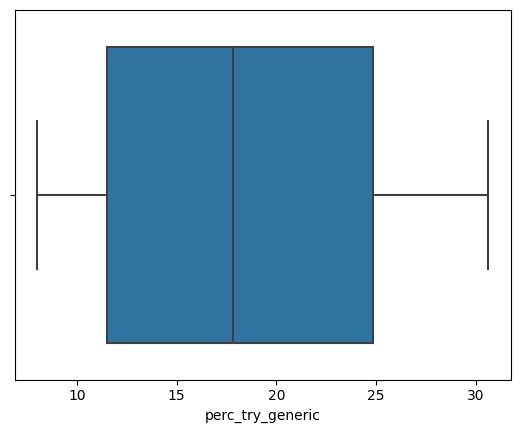

In [26]:
#make a boxplot of a numerical column of  a dataframe:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x=df_grp["perc_try_generic"])
plt.show()



RQ1. How common and what are the main characteristics of exception handling practices in Python open-source projects?

In [27]:
df_grp.loc[:, ["perc_trys_func", "perc_raise", "perc_n_try_else", "perc_finally"]]

,perc_trys_func,perc_raise,perc_n_try_else,perc_finally
0,7.44,7.44,14.59,19.77
1,6.48,6.48,11.48,36.07
2,3.43,3.43,7.73,6.87
3,4.04,4.04,3.11,26.32


In [28]:
df_total = df_grp.agg({'perc_trys_func': ['median', 'std'], 'perc_raise': ['median', 'std'], 'perc_n_try_else': ['median', 'std'], 'perc_finally': ['median', 'std']})
df_total

,perc_trys_func,perc_raise,perc_n_try_else,perc_finally
median,5.260000,5.260000,9.605000,23.045000
std,1.918982,1.918982,4.949629,12.250876


In [29]:
df_total = df_total.T[0:].reset_index()
df_total

,index,median,std
0,perc_trys_func,5.260,1.918982
1,perc_raise,5.260,1.918982
2,perc_n_try_else,9.605,4.949629
3,perc_finally,23.045,12.250876


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '')

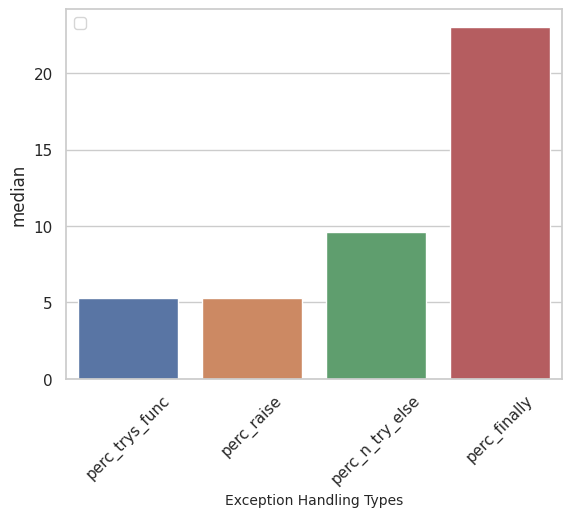

In [39]:
import seaborn as sns
sns.set_theme(style="whitegrid")

sns.barplot(data=df_total, x="index", y="median")
#plt.ylabel("Number of Commits", fontsize= 10)
plt.xlabel("Exception Handling Types", fontsize= 10)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

In [31]:
df_types = df.str_except_identifiers.str.split(" ").explode().value_counts().reset_index()

In [32]:
df_types = df_types[1:]

In [33]:
df_types.head(20)

,index,str_except_identifiers
1,Exception,293
2,ValueError,184
3,KeyError,175
4,AttributeError,173
5,TypeError,166
6,ImportError,106
7,NotImplementedError,85
8,RuntimeError,60
9,OSError,54
10,StopIteration,53


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '')

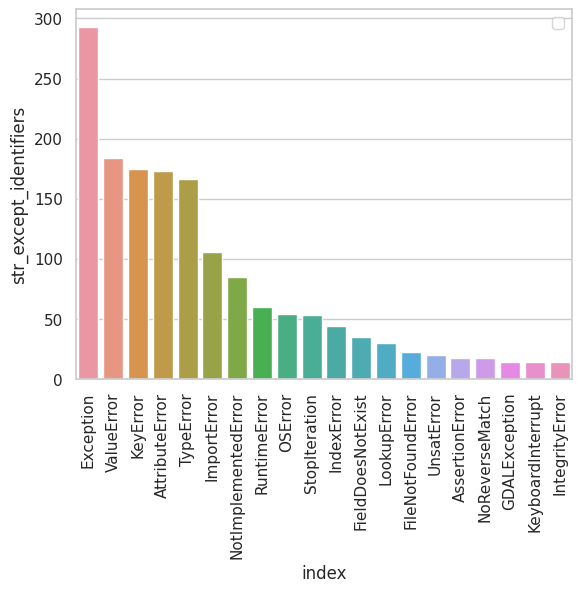

In [34]:
sns.set_theme(style="whitegrid")

fig = sns.barplot(data=df_types.head(20), x="index", y="str_except_identifiers").get_figure()
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)


RQ2. 

In [41]:
df_grp.columns

Index(['project', 'n_functions', 'n_try_except', 'perc_trys_func',
       'n_try_return', 'perc_n_try_return', 'n_generic_except',
       'perc_try_generic', 'n_try_pass', 'perc_try_pass', 'n_try_else',
       'perc_n_try_else', 'n_raise', 'perc_raise',
       'n_captures_try_except_raise', 'perc_try_except_raise',
       'n_captures_broad_raise', 'perc_raise_broad',
       'n_captures_misplaced_bare_raise', 'perc_raise_mis_bare', 'n_finally',
       'perc_finally'],
      dtype='object')

In [45]:
df_grp.loc[:, ["perc_try_generic", "perc_try_pass", "perc_raise_broad", "perc_try_except_raise", "perc_raise_mis_bare"]]

,perc_try_generic,perc_try_pass,perc_raise_broad,perc_try_except_raise,perc_raise_mis_bare
0,12.69,16.85,5.76,3.43,0.07
1,22.95,24.59,22.95,6.56,4.92
2,8.01,18.17,2.43,5.15,0.00
3,30.63,13.34,19.48,9.17,0.21


In [47]:
df_total = df_grp.agg({'perc_try_generic': ['median', 'mean'], 'perc_try_pass': ['median', 'mean'], 'perc_raise_broad': ['median', 'mean'], 'perc_try_except_raise': ['median', 'mean'],
                       'perc_raise_mis_bare': ['median', 'mean']})
df_total

,perc_try_generic,perc_try_pass,perc_raise_broad,perc_try_except_raise,perc_raise_mis_bare
median,17.82,17.5100,12.620,5.8550,0.14
mean,18.57,18.2375,12.655,6.0775,1.30


In [48]:
df_total = df_total.T[0:].reset_index()
df_total

,index,median,mean
0,perc_try_generic,17.820,18.5700
1,perc_try_pass,17.510,18.2375
2,perc_raise_broad,12.620,12.6550
3,perc_try_except_raise,5.855,6.0775
4,perc_raise_mis_bare,0.140,1.3000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '')

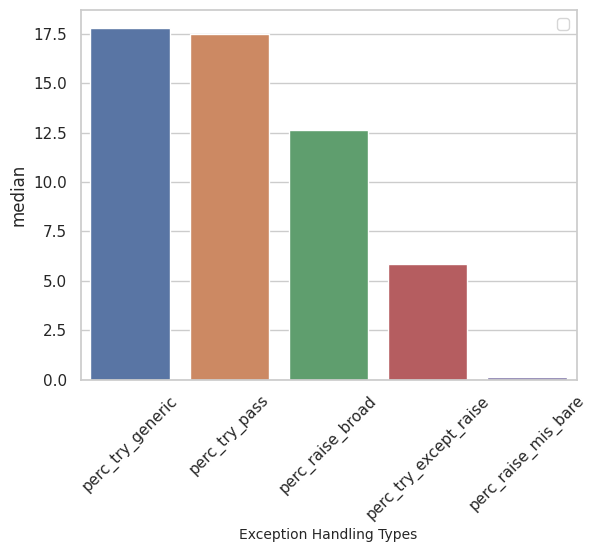

In [49]:
import seaborn as sns
sns.set_theme(style="whitegrid")

sns.barplot(data=df_total, x="index", y="median")
#plt.ylabel("Number of Commits", fontsize= 10)
plt.xlabel("Exception Handling Types", fontsize= 10)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)